# Facebook Prophet: Stock Market Prediction

**Objective:** a financial institution aimed to predict stock prices for various companies to optimize trading strategies.

**Approach:** historical stock price data, trading volumes, and financial indicators were used as input. FB Prophet was applied in order to forecast the stock market values.

**Outcome:** the accurate stock price predictions helped the financial institution make better investment decisions and improve trading strategies.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
df = pd.read_csv('../data_sets/Tesla.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [16]:
# Check for missing values
missing_values = df.isnull().sum()

# Basic statistical details
statistics = df.describe()

print('missing values: ')
print(missing_values)
print(' - - - - - - - - - -')
print('statistics: ')
print(statistics)

missing values: 
Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64
 - - - - - - - - - -
statistics: 
              Open         High          Low        Close        Volume  \
count  1692.000000  1692.000000  1692.000000  1692.000000  1.692000e+03   
mean    132.441572   134.769698   129.996223   132.428658  4.270741e+06   
std      94.309923    95.694914    92.855227    94.313187  4.295971e+06   
min      16.139999    16.629999    14.980000    15.800000  1.185000e+05   
25%      30.000000    30.650000    29.215000    29.884999  1.194350e+06   
50%     156.334999   162.370002   153.150002   158.160004  3.180700e+06   
75%     220.557495   224.099999   217.119999   220.022503  5.662100e+06   
max     287.670013   291.420013   280.399994   286.040009  3.716390e+07   

         Adj Close  
count  1692.000000  
mean    132.428658  
std      94.313187  
min      15.800000  
25%      29.884999  
50%     158.160004  
75%     

The dataset does not have any missing values. No need for data imputation.

The dataset contains 1692 records. For the Open, High, Low, Close, and Adj Close prices, the mean values are around 132. The standard deviation is quite high at around 94, indicating significant variability in Tesla's stock prices over this period. The minimum price in this dataset is around 15, and the maximum price is around 286. This shows the growth of Tesla's stock price over time. The Volume field, which represents the number of shares traded, varies significantly, with a minimum of 118,500 and a maximum of 37,163,900. 

Create some visualizations to better understand the data. Plot the closing price over time and the trading volume over time. This will give us a sense of how these quantities have changed over the period covered by the dataset.

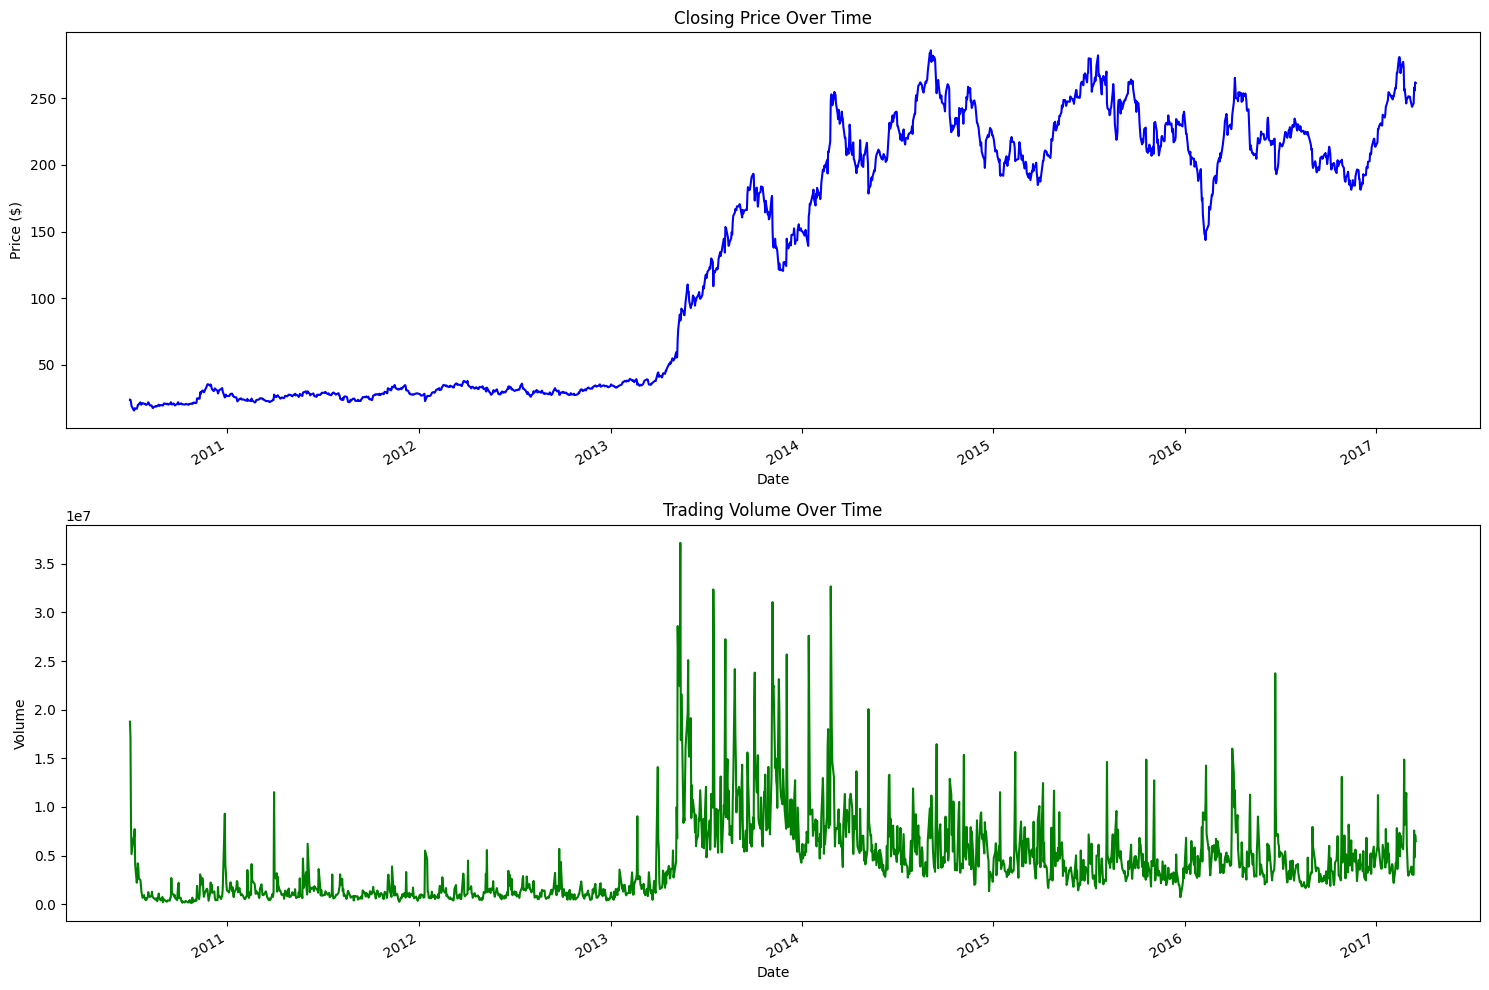

In [17]:
# Plot the closing price over time and the trading volume over time.

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index of the dataframe for plotting
df.set_index('Date', inplace=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plot the closing price over time
df['Close'].plot(ax=ax[0], color='blue')
ax[0].set_title('Closing Price Over Time')
ax[0].set_ylabel('Price ($)')

# Plot the trading volume over time
df['Volume'].plot(ax=ax[1], color='green')
ax[1].set_title('Trading Volume Over Time')
ax[1].set_ylabel('Volume')

# Improve layout
plt.tight_layout()
plt.show()

These plots provide a visual representation of how Tesla's closing price and trading volume have changed over time.

Closing Price Over Time: This plot shows that the closing price of Tesla stocks has generally increased over time, with some periods of significant growth and occasional declines. This is typical of stock price data, which can be quite volatile.

Trading Volume Over Time: This plot shows how the trading volume (i.e., the number of shares traded) has changed over time. There are some periods with particularly high trading volume, which may correspond to significant events or announcements related to Tesla.

Now that we've done a basic analysis of the data, let's proceed to the forecasting step. We'll use the Facebook Prophet library for this. Prophet is a powerful tool for time-series forecasting, and it can handle trends, seasonality, and holidays, which can all affect stock prices.

## Forecasting

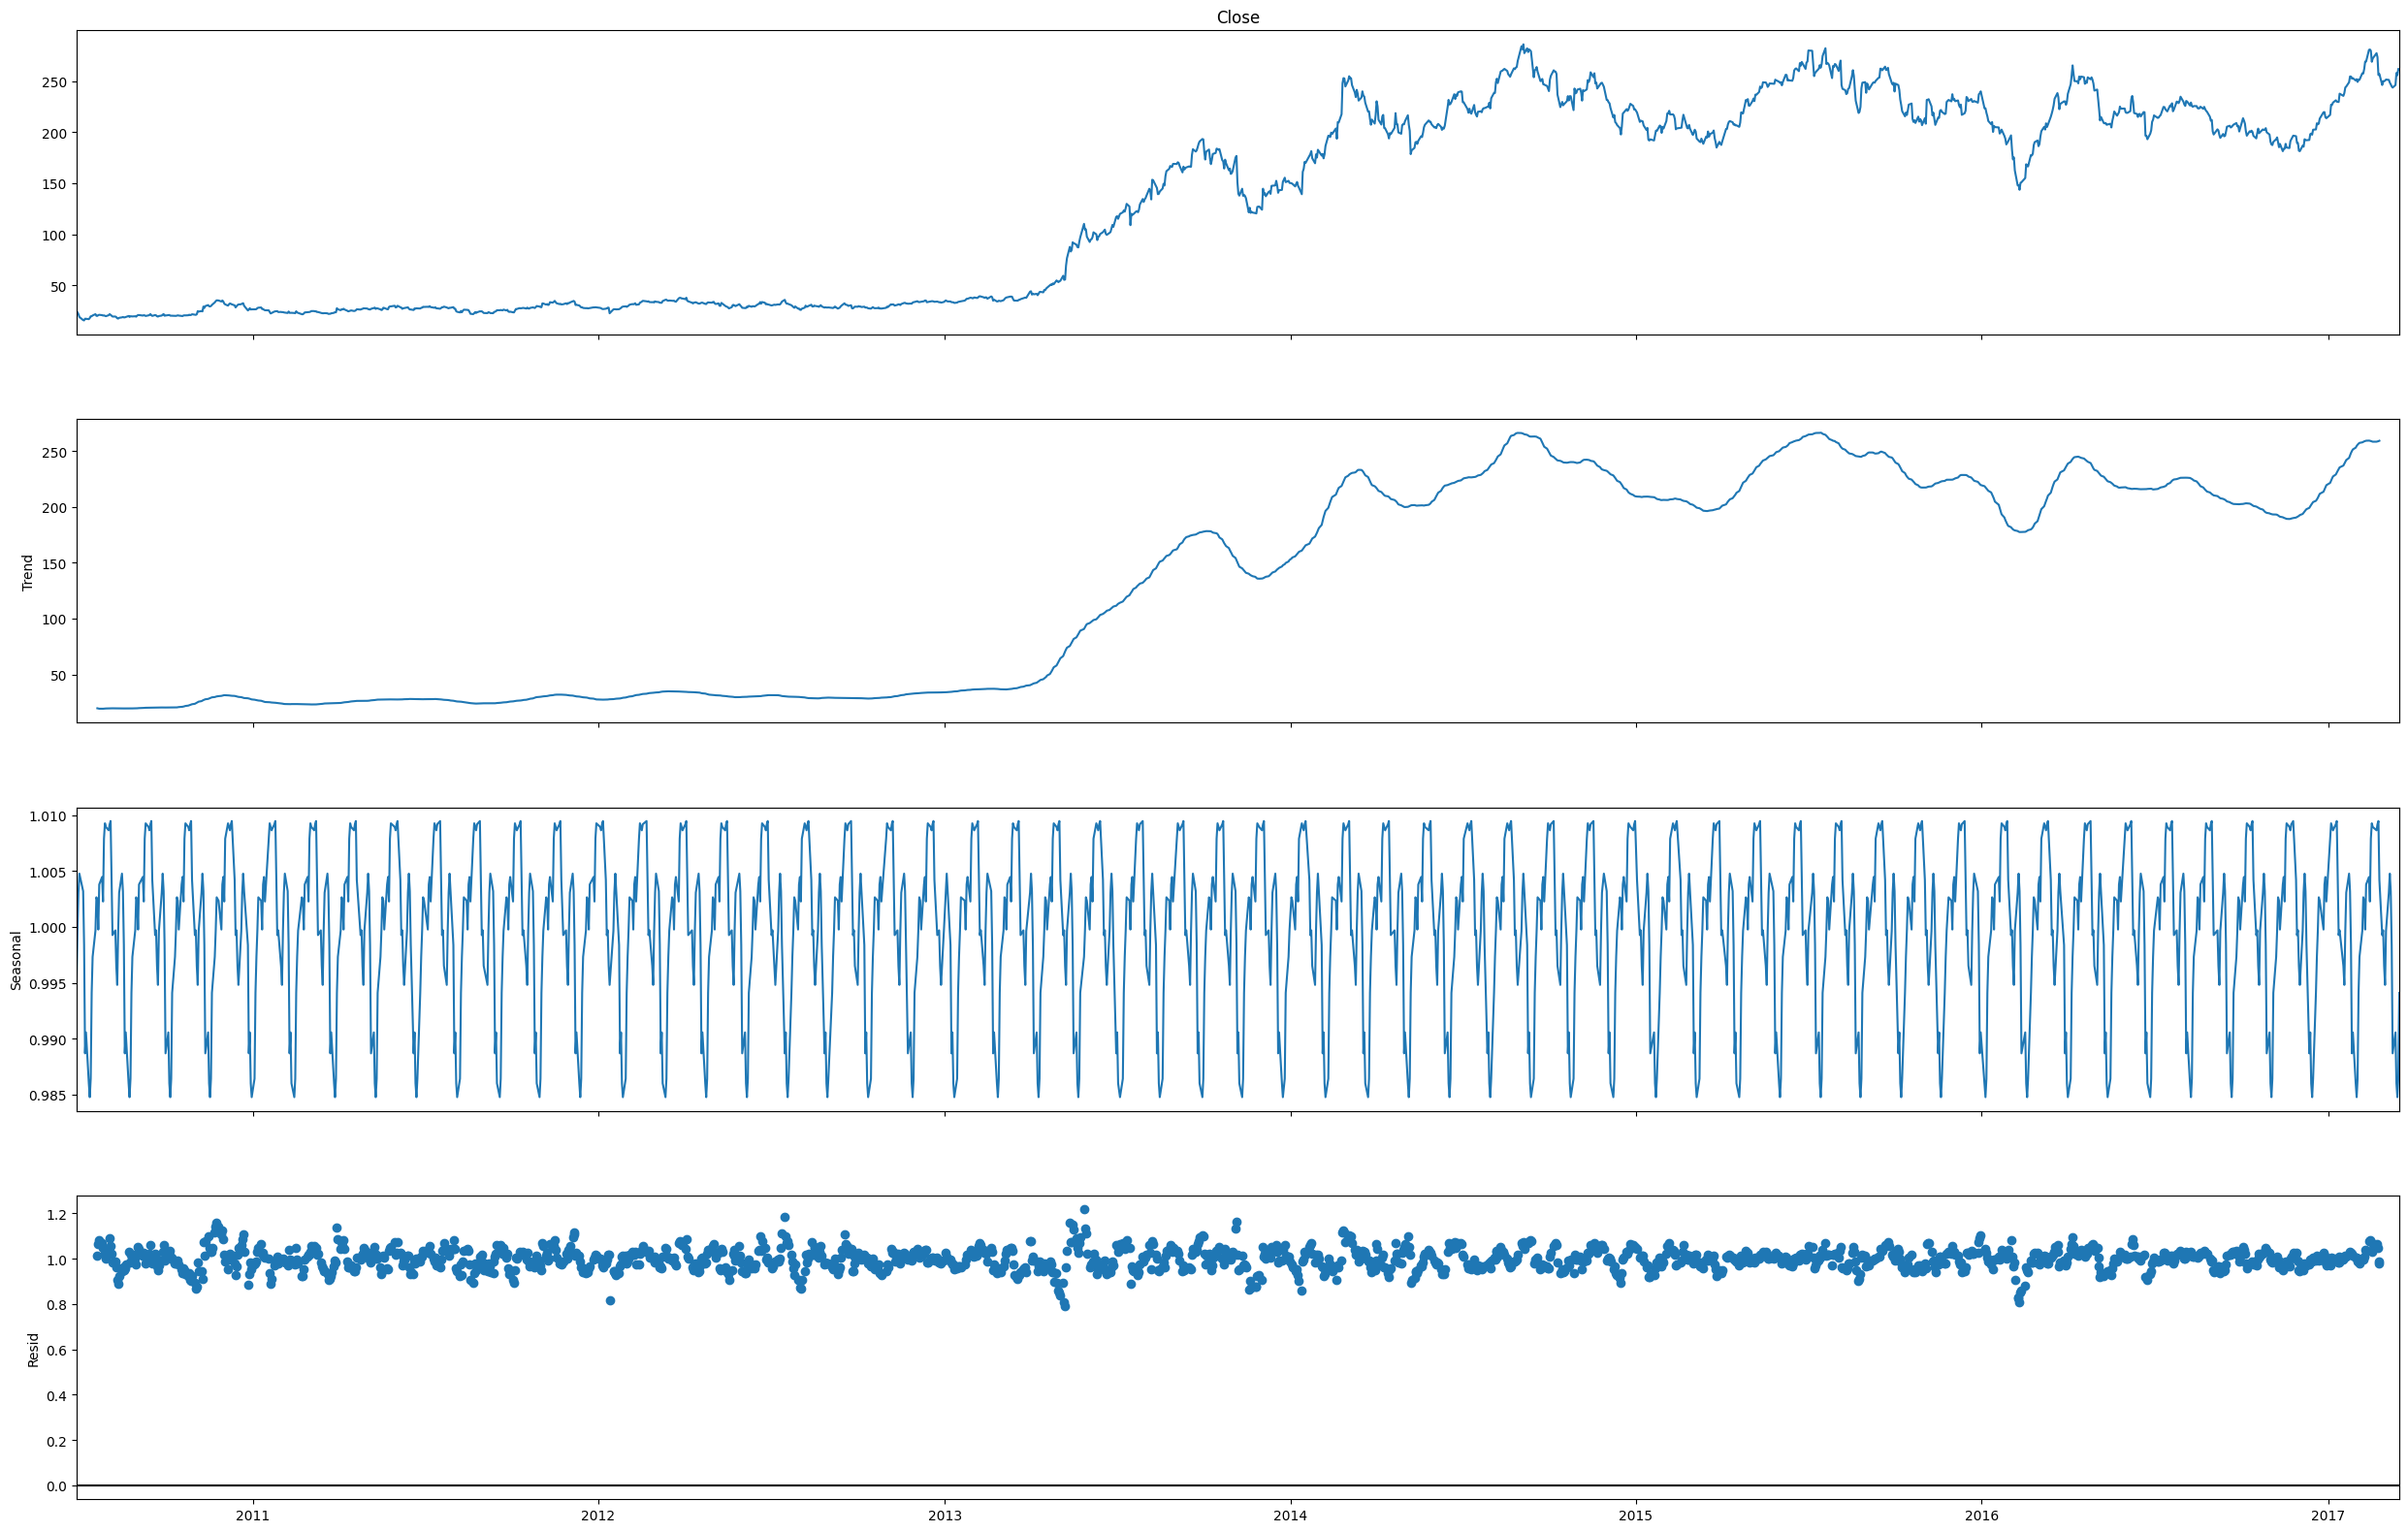

In [26]:
# Seasonality analysis

decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
fig = decomposition.plot()
fig.set_size_inches(28, 18)
plt.show()

The seasonal decomposition of the closing prices of Tesla's stock reveals the following:

Trend: The trend component shows a general upward trend in Tesla's stock price over the years, with some periods of decline. This indicates that the long-term movement of Tesla's stock price is upwards.

Seasonal: Some minor fluctuations suggest some recurring patterns that might be on a monthly basis.

Residuals: The residuals (the variation in the stock price not explained by the trend or seasonality) appear to have increased over time, indicating increasing volatility or unpredictability in Tesla's stock price.

Next, let's perform a volatility analysis. This will provide insight into how much the returns (percentage change in price) fluctuate over time. This fluctuation is a measure of the risk or uncertainty about the returns of the stock. A higher volatility means the price of the stock can change dramatically over a short time period in either direction, while lower volatility means that a stock's value does not fluctuate dramatically, but changes in value at a steady pace over a period of time.

## Volatility Analysis

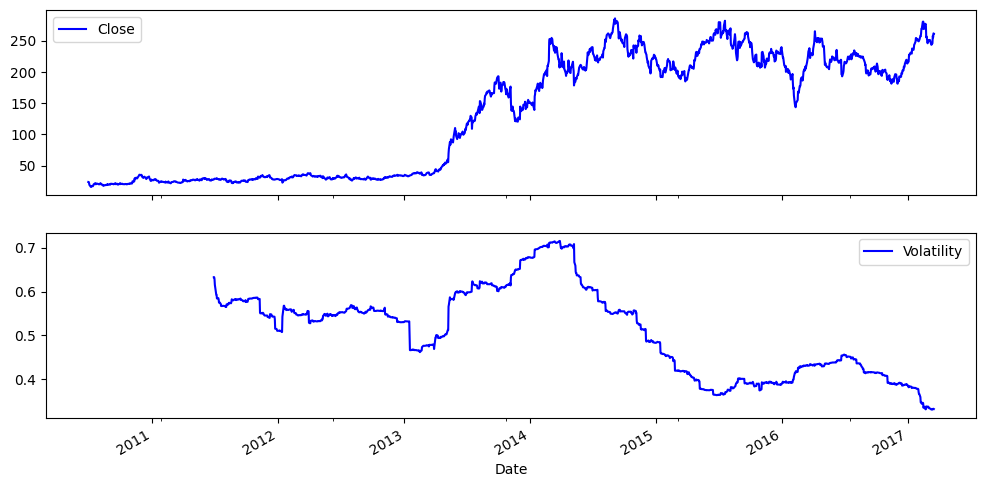

In [29]:
# Volatility analysis

df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=252).std() * np.sqrt(252)
df[['Close', 'Volatility']].plot(subplots=True, color='blue', figsize=(12, 6))
plt.show()

The volatility analysis provides the following insights:

Closing Prices: As seen before in the trend component of the seasonal decomposition, the closing prices of Tesla's stock show a general upward trend over time, with some periods of decline.

Volatility: The volatility, or the degree of variation in the returns of the stock over time, appears to have several peaks. This means there are periods when the returns change dramatically, indicating high risk or uncertainty during those periods. It's important to note that high volatility periods are not necessarily tied to drops in the stock price; they represent periods of significant price change in either direction.

Next, we'll perform a moving average analysis. The moving average is often used to identify trend direction and to smooth out price and volume fluctuations (or "noise") that can confuse interpretation. In this case, we'll calculate and plot the 10-day and 50-day moving averages along with the closing prices. The 10-day moving average gives us a short-term trend direction, while the 50-day moving average gives a longer-term trend direction.

## Moving average analysis

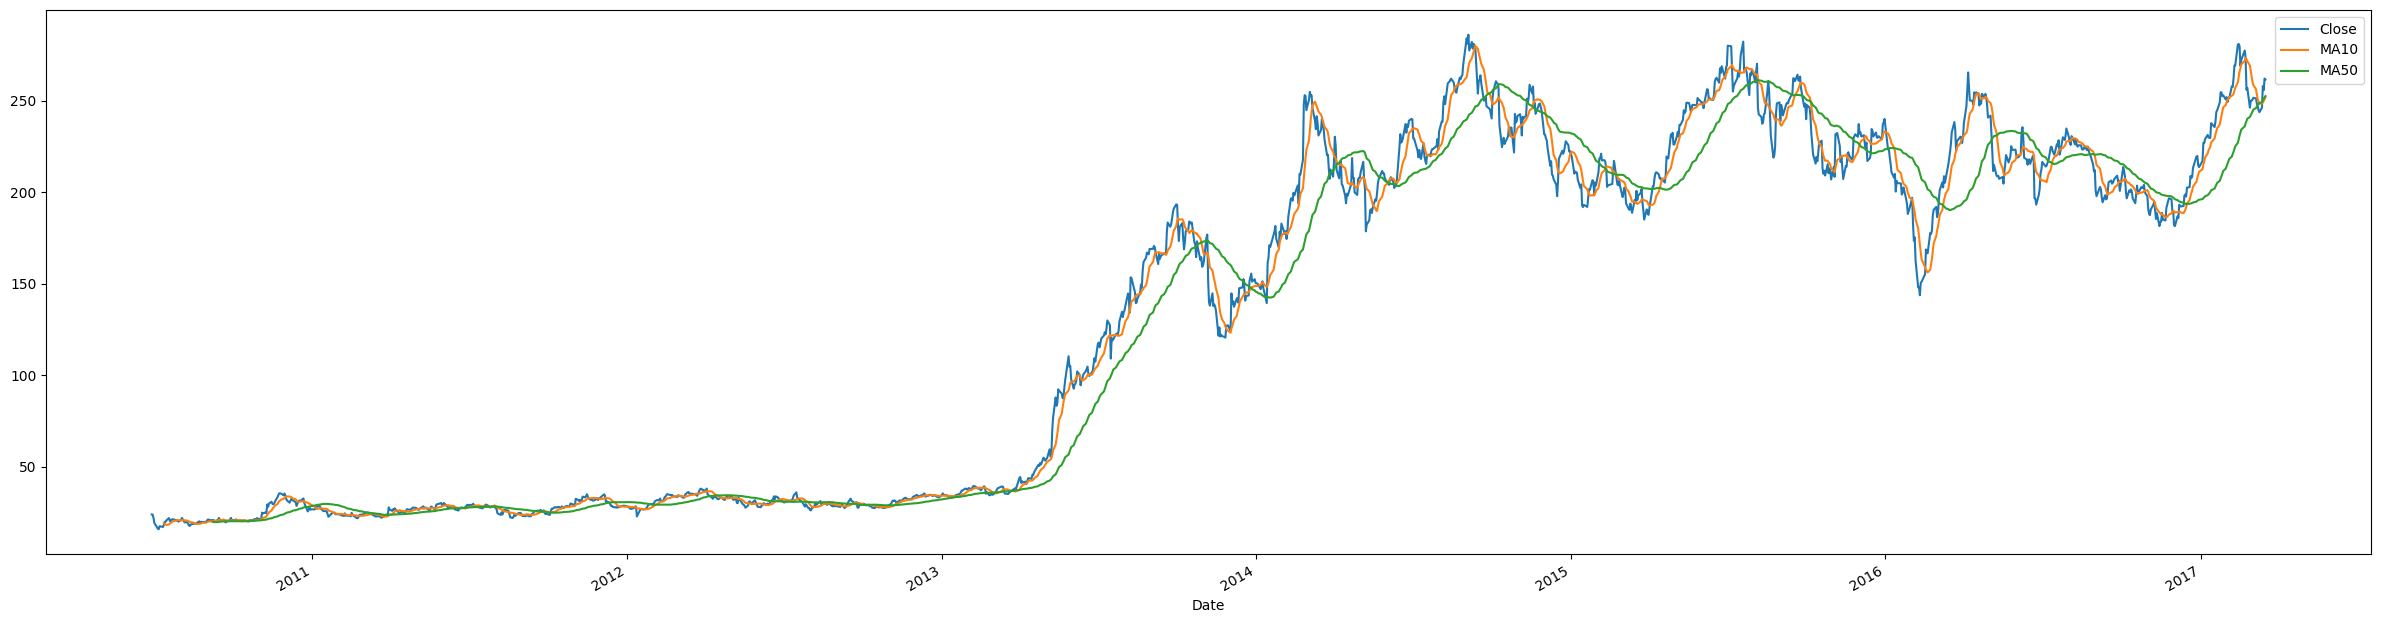

In [33]:
# moving average analysis

df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df[['Close', 'MA10', 'MA50']].plot(label='Tesla', figsize=(30,8))
plt.show()

The moving average analysis yields the following insights:

Closing Prices: As previously observed, the closing prices of Tesla's stock have a general upward trend over time, with some periods of decline.

10-Day Moving Average (MA10): The 10-day moving average shows the short-term trend of Tesla's stock price. When the closing price is above the 10-day moving average, it may indicate an upward trend in the short term, and vice versa.

50-Day Moving Average (MA50): The 50-day moving average shows the longer-term trend of Tesla's stock price. When the closing price is above the 50-day moving average, it may indicate an upward trend in the long term, and vice versa.

One common strategy used by some traders is to look for crossings of different moving averages as a signal for potential buying or selling opportunities. For example, when the MA10 crosses above the MA50 (a "bullish crossover"), it could be seen as a buy signal, as it indicates that the short-term trend is moving upwards faster than the long-term trend. Conversely, when the MA10 crosses below the MA50 (a "bearish crossover"), it could be seen as a sell signal.

Next, let's analyze the returns of the stock. This will give us an idea of how much the stock price changes from day to day. A positive return means the stock price increased, while a negative return means it decreased.

## Return Analysis

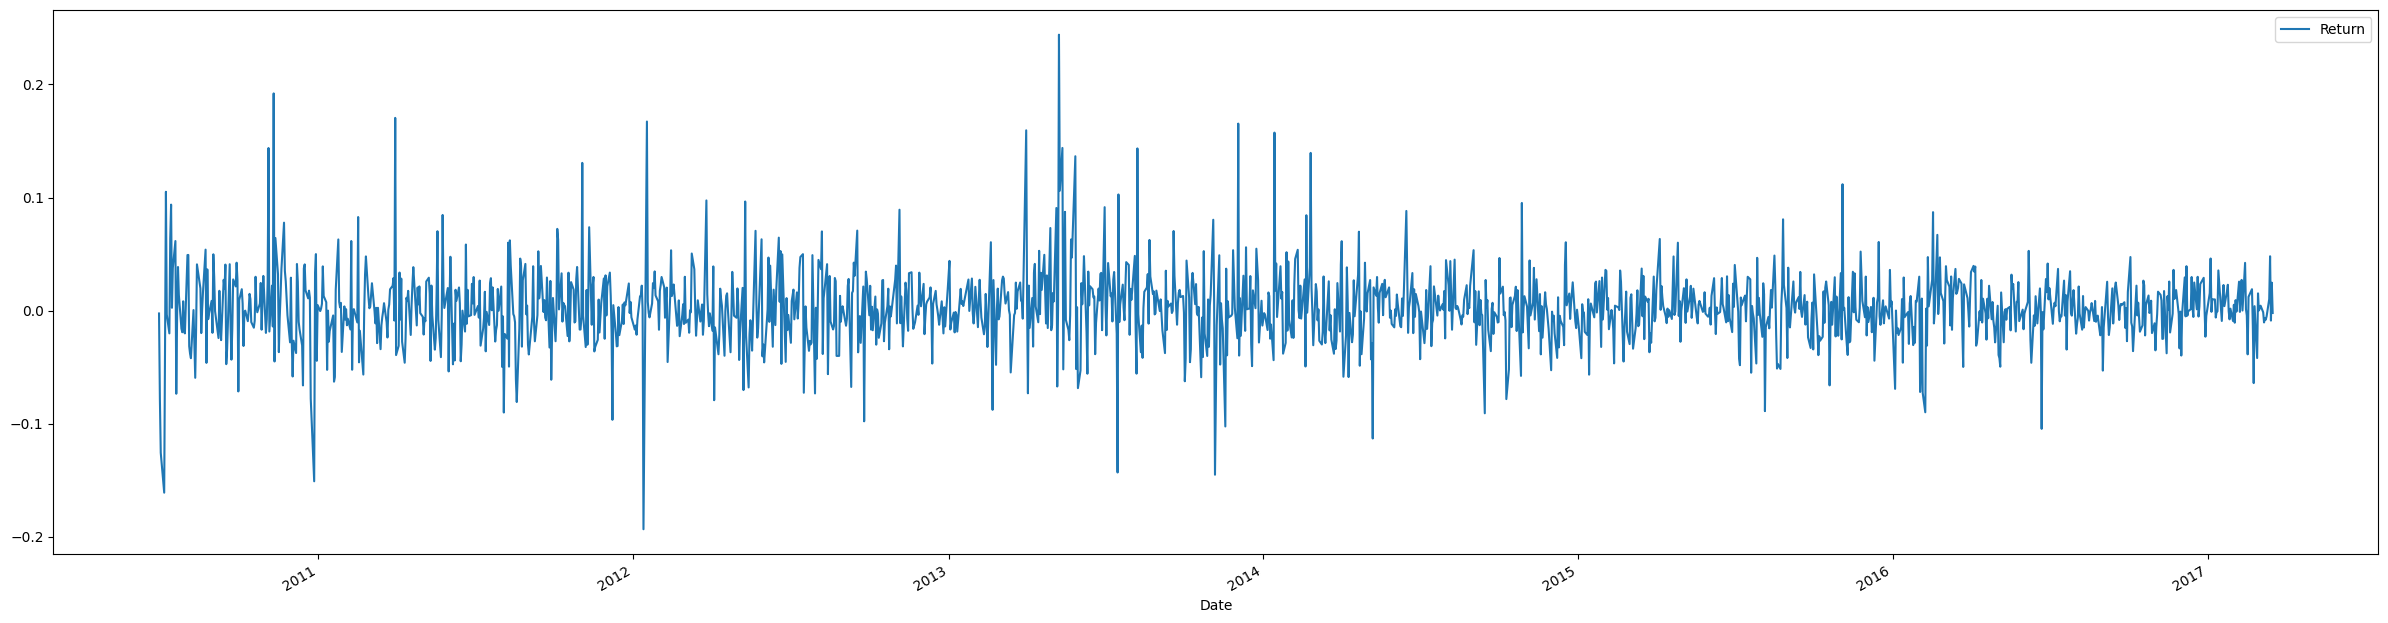

In [37]:
# Return analysis

df['Return'] = df['Close'].pct_change()
df[['Return']].plot(label='Return', figsize=(30,8))
plt.show()

The return analysis chart illustrates the daily percentage change in Tesla's stock price. Here are some observations:

Return: The daily return fluctuates around 0, with a mix of positive and negative returns. This indicates that the stock price has days of both gains and losses.

The magnitude of these daily returns provides some indication of the stock's volatility. Larger swings (both up and down) indicate more volatility. As seen in the chart, there are periods with higher volatility (larger fluctuations in returns) and periods with lower volatility (smaller fluctuations in returns).

Some extreme spikes represent days with particularly significant price changes. These might be related to specific events, such as earnings announcements, changes in the broader market, or other news related to the company or its industry.

Remember, a positive return means the stock price increased from the previous day, while a negative return means it decreased.

For forecasting with Prophet, we need to prepare the data in a specific format. The dataframe should have two columns: ds and y. The ds (datestamp) column should contain the dates, and the y column should contain the values we want to predict or forecast (in this case, the Close price). So, let's prepare the data accordingly.

## Forecasting with Facebook Prophet

In [39]:
# Prepare the data for Prophet
prophet_df = df.reset_index()[['Date', 'Close']]
prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

prophet_df.head()

,ds,y
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [40]:
# instantiate the Prophet model

model = Prophet()

# Fit the model to the data set
model.fit(prophet_df)

# specify the number of days for predictions
future = model.make_future_dataframe(periods=365)

# use the model to make predictions
forecast = model.predict(future)

18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing


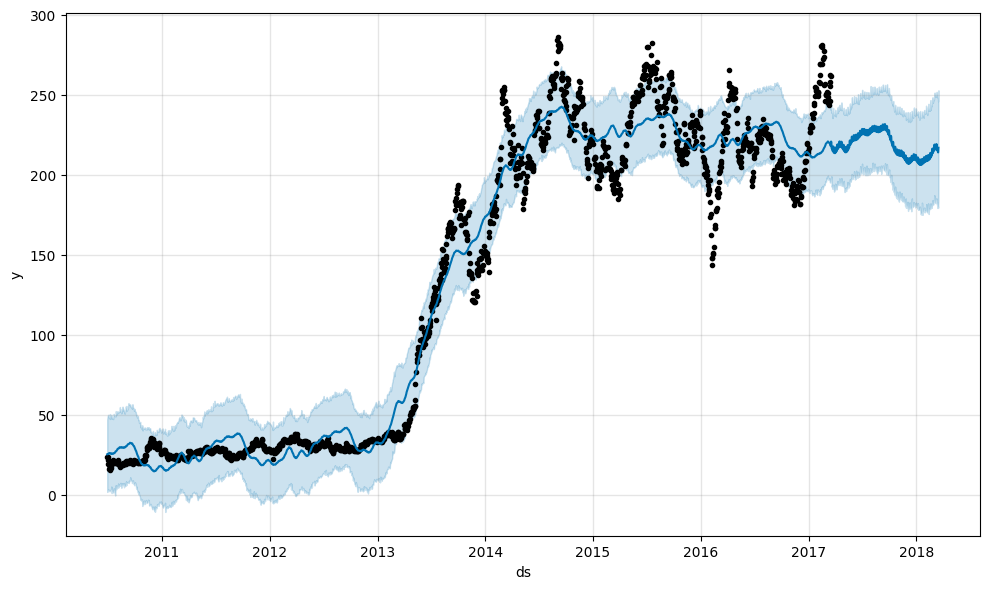

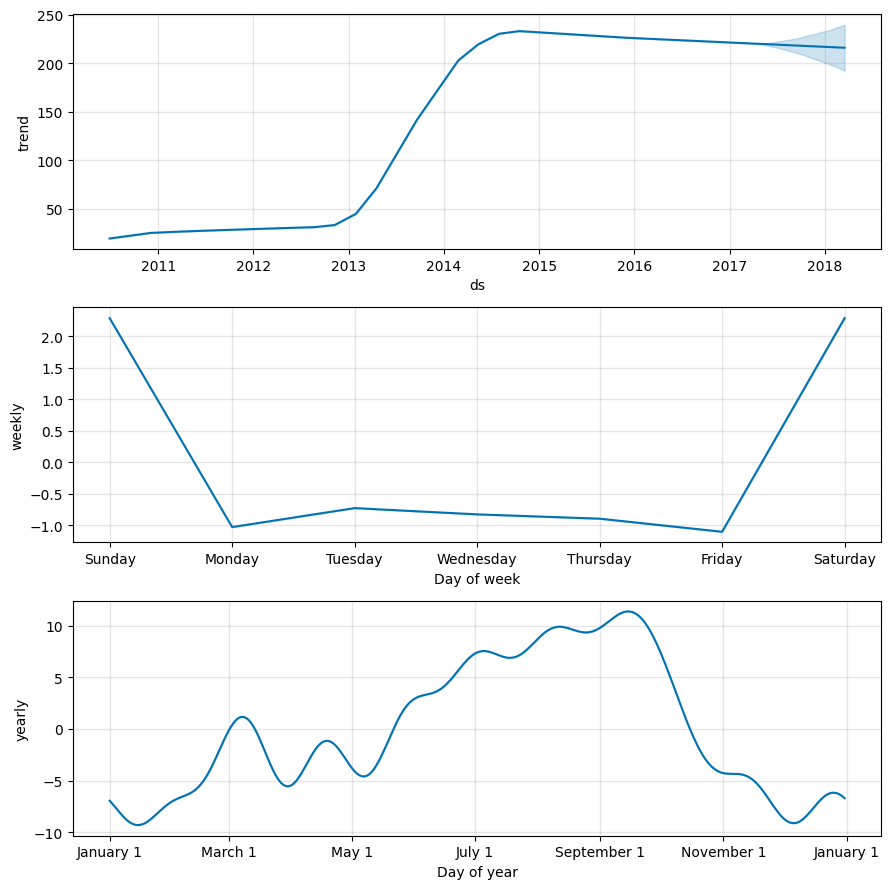

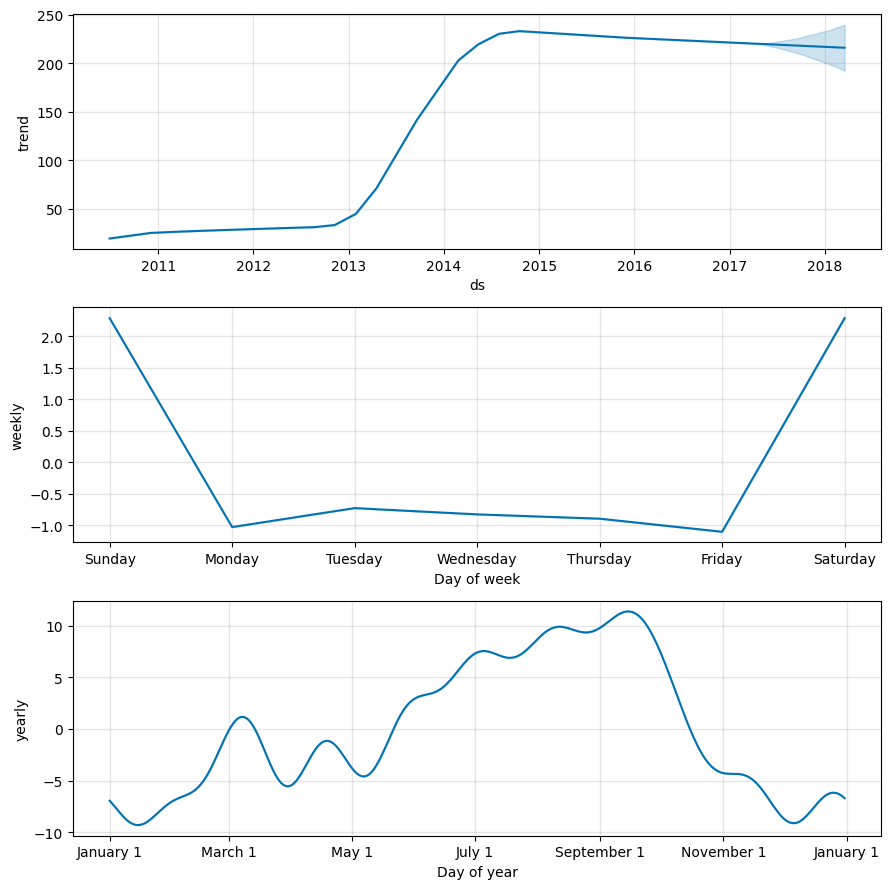

In [43]:
# visualize the forecast

model.plot(forecast)
plt.show()

# if you want to see the components of the forcast, you can use:
model.plot_components(forecast)